In [198]:
import pandas as pd
import numpy as np
from stable_baselines import A2C
from stable_baselines import PPO2
from stable_baselines import DDPG
from scipy.special import softmax
from stable_baselines.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
import time


In [199]:
# hyperparameters
stock_dim = 30
action_dim = stock_dim + 1
feature_size = 6
observation_dim = feature_size * stock_dim + 2
initial_asset = 100000
cash_bias = 10000
softmax_regularization = 10000

In [200]:
# create environment
class tradeEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self,df,day=0,asset=initial_asset):

        self.day = day 
        self.df = df

        # initialize asset 
        self.asset = asset
        self.asset_memory = [asset]  

        # initialize account
        self.account = np.array([asset] + [0]*stock_dim)
        self.asset_proportion = np.array([1] + [0]*stock_dim) 
        self.account_memory = [self.account]

        # action space & observation space
        self.action_space = gym.spaces.Box(low=-1,high=1,shape=(action_dim,)) # grading method + softmax
        self.observation_space = gym.spaces.Box(low=-np.inf,high=np.inf,shape=(observation_dim,)) 

    def __get_obs(self,day):
        
        # state -> day's obs / data -> df.loc[day,:]
        data = self.df.loc[day,:]
        state = self.account.tolist() + [1] + data.adjcp.values.tolist() + data.macd.values.tolist() + data.rsi.values.tolist() + data.cci.values.tolist() + data.adx.values.tolist()
        # [  cash,stock1_on_hand,stock2_on_hand,...,stock30_on_hand,  1,stock1_price,stock2_price,...,stock30_price,  30*feature1 ,  30*feature2 , 30*feature3 , 30*feature4  ]   ->   dim: 182
        state = np.array(state).reshape(observation_dim,)
        return state

    def show_asset(self,format_string="r"):
        plt.plot(self.asset_memory,format_string)
        
    def show_stock_hold(self,stock_idx):
        mat = np.array(env.account_memory)
        mat = mat.T
        plt.plot(mat[stock_idx],"r")


    def step(self,actions):

        # calculate today's asset
        today_obs = self.__get_obs(self.day)
        today_prices = np.array(today_obs[action_dim:2*action_dim]) 
        self.asset = np.dot(self.account,today_prices) # todo 现金的价格标注为 1
        self.asset_memory.append(self.asset)

        # action asset proportion
        actions = actions * softmax_regularization  # aggressive trade strategy
        actions[0] += cash_bias                     # mild trade strategy 
        self.asset_proportion = softmax(actions)
        self.account = self.asset * self.asset_proportion / today_prices 
        self.account_memory.append(self.account)

        # calculate reward
        tomorrow_obs = self.__get_obs(self.day+1)
        tomorrow_prices = np.array(tomorrow_obs[action_dim:action_dim*2])
        tomorrow_asset = np.dot(self.account,tomorrow_prices)
        reward = tomorrow_asset - self.asset

        # step update
        self.day += 1
        done = self.day >= len(self.df.index.unique()) - 1

        # if done:
        #     plt.plot(self.asset_memory,"r")
        #     plt.savefig("result_fig.png")
        #     plt.close()


        return tomorrow_obs , reward , done , {}


    def reset(self):

        asset = initial_asset
        day = 0

        self.day = day 

        # initialize asset 
        self.asset = asset
        self.asset_memory = [asset]  

        # initialize account
        self.account = np.array([asset] + [0]*stock_dim)
        self.asset_proportion = np.array([1] + [0]*stock_dim)

        today_obs = self.__get_obs(0)

        return today_obs


    def render(self, mode="human"):

        today_obs = self.__get_obs(self.day)

        return today_obs







In [201]:
def train_A2C(model_name,train_env,time_steps=70000):
    model = A2C("MlpPolicy",env=train_env,verbose=1)
    model.learn(time_steps) 
    model.save("model/"+model_name)
    return model

def train_PPO2(model_name,train_env,time_steps=70000,batch_size=4):
    model = PPO2("MlpPolicy",env=train_env,nminibatches=batch_size,verbose=1)
    model.learn(time_steps) 
    model.save("model/"+model_name)
    return model

def train_DDPG(model_name,train_env,time_steps=70000):
    model = DDPG("MlpPolicy",env=train_env,verbose=1)
    model.learn(time_steps)
    model.save("model/"+model_name)
    return model

In [202]:
# load data set
data_df = pd.read_csv('dataSet/stock_data/done_data.csv')
train_set = data_df[(data_df['datadate'] < 20151001)]
test_set = data_df[(data_df['datadate'] > 20151001) & (data_df['datadate'] < 20190707)]
nightmare_set = data_df[(data_df['datadate'] > 20190707)]

# preprocess data set
train_set = train_set.sort_values(['datadate','tic'],ignore_index=True) 
train_set.index = train_set.datadate.factorize()[0]
env = tradeEnv(train_set)

test_set = test_set.sort_values(['datadate','tic'],ignore_index=True) 
test_set.index = test_set.datadate.factorize()[0]
t_env = tradeEnv(test_set)


# catastrophy happened in 2020
nightmare_set = nightmare_set.sort_values(['datadate','tic'],ignore_index=True) 
nightmare_set.index = nightmare_set.datadate.factorize()[0]
hell_env = tradeEnv(nightmare_set)

# check_env(env)


2022-05-10 20:06:36.490086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3d:00.0
2022-05-10 20:06:36.490149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-10 20:06:36.490291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-10 20:06:36.490311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-05-10 20:06:36.490328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-05-10 20:06:36.490343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2022-05-10 20:06:36.490359: I tensorflow/stream_executor/

--------------------------------------
| reference_Q_mean        | 555      |
| reference_Q_std         | 1.23e+03 |
| reference_action_mean   | -0.0586  |
| reference_action_std    | 0.994    |
| reference_actor_Q_mean  | 589      |
| reference_actor_Q_std   | 1.23e+03 |
| rollout/Q_mean          | 178      |
| rollout/actions_mean    | -0.0026  |
| rollout/actions_std     | 0.97     |
| rollout/episode_steps   | 1.7e+03  |
| rollout/episodes        | 5        |
| rollout/return          | 9.02e+04 |
| rollout/return_history  | 9.02e+04 |
| total/duration          | 48.4     |
| total/episodes          | 5        |
| total/epochs            | 1        |
| total/steps             | 9998     |
| total/steps_per_second  | 206      |
| train/loss_actor        | -365     |
| train/loss_critic       | 1.84e+06 |
| train/param_noise_di... | 0        |
--------------------------------------

---------------------------------------
| reference_Q_mean        | 1.25e+03  |
| reference_Q_std     

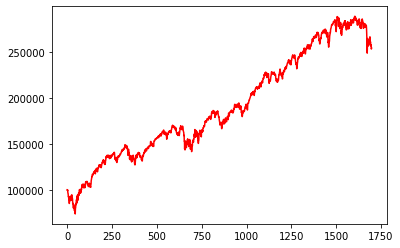

In [175]:
model = train_DDPG("my_DDPG",env,20000)

obs = env.reset() 


for i in range(len(train_set.index.unique())-1):
    act , _ = model.predict(obs)
    obs , reward , done , info = env.step(act) 

env.show_asset()
print(env.asset)


In [182]:
def test_model(model,target_set):
    
    target_env = tradeEnv(target_set)
    obs = target_env.reset()

    for i in range(len(target_set.index.unique())-1):
        act , _ = model.predict(obs)
        obs , reward , done , info = target_env.step(act)

    target_env.show_asset("r")
    return target_env.asset

def random_strategy(target_set):

    target_env = tradeEnv(target_set)
    obs = target_env.reset()

    for i in range(len(target_set.index.unique())-1):
        act = np.random.randn(action_dim)
        obs , reward , done , info = target_env.step(act) 

    target_env.show_asset("b")
    return target_env.asset


    

DRL-strategy: 104496.53789541707
Random-strategy: 97541.87087776641


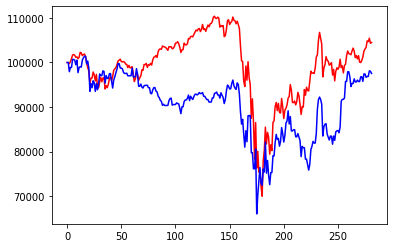

In [204]:
# create super-agent
print("DRL-strategy:",test_model(model,nightmare_set))
print("Random-strategy:",random_strategy(nightmare_set))

In [141]:
# test block1

test_set = test_set.sort_values(['datadate','tic'],ignore_index=True) 
test_set.index = test_set.datadate.factorize()[0]
t_env = tradeEnv(test_set)

model = A2C("MlpPolicy",t_env,verbose=1)
model.learn(70000) 
model.save("conflict_model")


Wrapping the env in a DummyVecEnv.


2022-05-09 21:45:01.178737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:40:00.0
2022-05-09 21:45:01.178813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-09 21:45:01.178966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-09 21:45:01.178987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-05-09 21:45:01.179004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-05-09 21:45:01.179020: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2022-05-09 21:45:01.179035: I tensorflow/stream_executor/

---------------------------------
| explained_variance | 0.000253 |
| fps                | 22       |
| nupdates           | 1        |
| policy_entropy     | 44       |
| total_timesteps    | 5        |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00045 |
| fps                | 318      |
| nupdates           | 100      |
| policy_entropy     | 44       |
| total_timesteps    | 500      |
| value_loss         | 7.97e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000902 |
| fps                | 328      |
| nupdates           | 200      |
| policy_entropy     | 44       |
| total_timesteps    | 1000     |
| value_loss         | 3.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000839 |
| fps                | 330      |
| nupdates           | 300      |
| policy_entropy     | 44       |
| total_timest

182827.57675407705


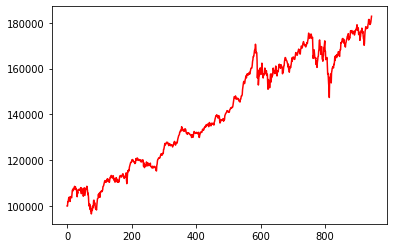

In [57]:
# victim cache

#model = PPO2.load("temp_model")

obs = env.reset()


for i in range(len(train_set.index.unique())-1):
    act , _ = model.predict(obs)
    obs , reward , done , info = env.step(act) 

env.show_asset()
print(env.asset)

# plt.plot(env.asset_memory,"r")
# plt.savefig("test_fig.png")
# plt.close()
    

104496.53789541707


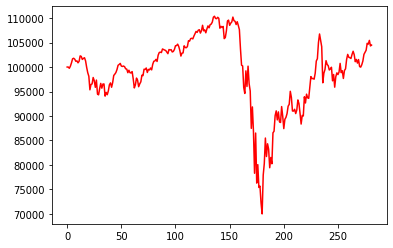

In [203]:
# terminal 
# model = DDPG.load("model/bad_a2c")

#model = train_DDPG("my_DDPG",hell_env,200000)

obs = hell_env.reset() 


for i in range(len(nightmare_set.index.unique())-1):
    act , _ = model.predict(obs)
    obs , reward , done , info = hell_env.step(act) 

hell_env.show_asset()
print(hell_env.asset)
